In [1]:
import numpy as np 
import scipy.sparse as sp
import scipy.sparse.linalg as spl
import matplotlib.pyplot as plt
import time 
import graph_tool as gt

from utils import PositivePart, Grid, ControlVolumes, VascularGraph, SplitVessels, gmres_counter

In [2]:
class gmres_counter(object):
    def __init__(self, disp=10):
        self._disp = disp
        self.niter = 0
        self.rks = []

    def __call__(self, rk=None):
        self.niter += 1
        if self.niter%self._disp==0:
            # if isinstance(rk, cp.ndarray):
            #     rk = rk.get()
            self.rks.append(rk)
            print('iter %3i\trk = %s' % (self.niter, str(rk)))

    def __enter__(self):
        self.t1 = time.time()
        return self
    def __exit__(self, type, value, traceback):
        t = (time.time() - self.t1)/60
        plt.plot(self._disp * (1+np.arange(len(self.rks))), self.rks)
        plt.xlabel("Number of iterations")
        plt.ylabel("Residual (relative?)")
        plt.title(f"Solving time: {t}min")
        plt.show()

# Parameters

In [3]:
convertMicron = 1e-5

# Vessel parameters
vy = 2*50 * convertMicron # Length of the vessel, along the y-axis, in micron
r = 5 * convertMicron # Radius of the vessel, in micron
# Grid parameters
nx,ny,nz = 25,2*50,25      # Number of discretization point in each direction
lx,ly,lz = 50 * convertMicron, 2*100 * convertMicron, 50 * convertMicron # Cube's sides lengths, in micron
cx,cy,cz = -25 * convertMicron, -25 * convertMicron, -25 * convertMicron # Location of the bottom, left, back corner of the cube, in microns
h = lx/nx # Voxel size length
assert all(l/n==h for l,n in zip((lx,ly,lz), (nx,ny,nz))), f"Currently, the discretization assumes the voxels to be cubes (all sides must have the same length). Found {[l/n for l,n in zip((lx,ly,lz), (nx,ny,nz))]}"

# Physiological parameters
convertVolumetricFlow = (1e-6)/60 
q0 = 1e-1 * convertVolumetricFlow # 5 mu^3/min to L/s
Hd = 0.4 # Haematocrit 
C0 = 0.02 # Mol/L (What is that?)
# alpha = 1.2e-6 # Mol/L/mmHg, oxygen plasma solubility
alpha = 2.82e-5 * 1e3 # mlO2/mmHg/L from "Dynamic model of oxygen transport from capillaries to tissue with moving red blood cells." 
alpha_t = 3.89e-5 * 1e3 # mlO2/mmHg/L from "Dynamic model of oxygen transport from capillaries to tissue with moving red blood cells." 
Gamma_v = 1.77e3 * (convertMicron**2) # in mum2/s the permeability of the vessel wall to O2
h_v = 1 * convertMicron # In micons, the vessel wall thickness
Gamma_t = 1.8e3 * (convertMicron**2) # in mum2/s the oxygen diffusivity in tissue
k_t = 0.4 # 1/s, the oxygen consumption rates

# Boundary conditions
RO2 = 62.36 # Ideal gas constant for O2, L.mmHg/(K.Mol)
Tret = 308.15 # 35*C in Kelvin, the temperature of the retina (roughly)
cIn = 50 * alpha # mmHg to molO2/L = free plasma oxygen concentration
ctBC = 40 * alpha_t # / (RO2 * Tret)  # mmHg to molO2/L 

print(f"Boundary conditions: {cIn=}, {ctBC=}")
print(f"Dynamics parameters: {Gamma_t=}, {Gamma_v=}")
print(f"Vessel parameters: {r=}, {vy=}, {q0=}, {h_v=}")
print(f"Grid parameters: {(lx,ly,lz)=}, {(cx,cy,cz)=}, {h=}")

Boundary conditions: cIn=1.41, ctBC=1.5559999999999998
Dynamics parameters: Gamma_t=1.8000000000000002e-07, Gamma_v=1.7700000000000004e-07
Vessel parameters: r=5e-05, vy=0.001, q0=1.6666666666666667e-09, h_v=1e-05
Grid parameters: (lx,ly,lz)=(0.0005, 0.002, 0.0005), (cx,cy,cz)=(-0.00025, -0.00025, -0.00025), h=2e-05


In [4]:
print(f"{Gamma_v/(q0*h_v)=}")
print(f"Intravascular inlet O2 concentratioN: {cIn=}")
print(f"Tissue O2 concentration (boundary condition): {ctBC=}")
print(f"{Gamma_t/k_t=}")
print(f"{22.4*alpha=}, {1/(RO2*Tret)=}")

Gamma_v/(q0*h_v)=10620000.000000002
Intravascular inlet O2 concentratioN: cIn=1.41
Tissue O2 concentration (boundary condition): ctBC=1.5559999999999998
Gamma_t/k_t=4.5000000000000003e-07
22.4*alpha=0.6316799999999999, 1/(RO2*Tret)=5.203933299313488e-05


# Test convection

### Create vessel graph

In [5]:
p0 = np.array([0.0,0,0.0]) 
p1 = np.array([0.0,vy,0.0]) 
n = (p1-p0)/np.linalg.norm(p0-p1, 2)
l = np.linalg.norm(p0-p1, 2)
k = 3

VAG = VascularGraph()
VAG.add_edge_list([(i,i+1,l/k, r) for i in range(k)], eprops=[('length', 'float'), ('radius','float')])
pos = VAG.new_vertex_property("vector<double>")
pos.set_2d_array(np.array([p0+t*(p1-p0) for t in np.linspace(0,1,endpoint=True, num=k+1)]).T)

VAG.vp['position'] = pos
VAG.vp['plexus'] = VAG.new_vertex_property("int", val=0)
VAG.vp['sort'] = VAG.new_vertex_property('int', vals=gt.topology.topological_sort(VAG))

# gt.draw.graph_draw(VAG, pos=VAG.vp['position'])
CV = ControlVolumes(Grid(origin=(cx,cy,cz), 
                         sideLengths=(lx,ly,lz), 
                         shape=(nx,ny,nz)), 
                         vessels=VAG)

In [6]:
print([np.array(p)/convertMicron for p in VAG.vp['position']])

[array([0., 0., 0.]), array([ 0.        , 33.33333333,  0.        ]), array([ 0.        , 66.66666667,  0.        ]), array([  0., 100.,   0.])]


### Split to mesh size

In [7]:
SplitVessels(CV, CV.grid.h)
q = CV._vessels.new_edge_property("float", q0) # Flow in the vessel (constant -- conservation of mass)
CV._vessels.ep['q'] = q

Refining vascular mesh: 100%|██████████| 3/3 [00:00<00:00, 1313.59edges/s]


### Label

In [8]:
coupling = CV.LabelMesh(h_v)
# CV.ToVTK("LabelGridOneVessel.vtk")

Labelling...:   0%|          | 0/54 [00:00<?, ?edge/s]

Labelling...: 100%|██████████| 54/54 [00:00<00:00, 1333.72edge/s]


G.num_edges()=174, G.num_vertices()=62555
G.num_edges()=377, G.num_vertices()=62555
G.num_edges()=580, G.num_vertices()=62555
G.num_edges()=769, G.num_vertices()=62555
G.num_edges()=958, G.num_vertices()=62555
G.num_edges()=1161, G.num_vertices()=62555
G.num_edges()=1350, G.num_vertices()=62555
G.num_edges()=1539, G.num_vertices()=62555
G.num_edges()=1701, G.num_vertices()=62555
G.num_edges()=1863, G.num_vertices()=62555
G.num_edges()=2052, G.num_vertices()=62555
G.num_edges()=2256, G.num_vertices()=62555
G.num_edges()=2418, G.num_vertices()=62555
G.num_edges()=2580, G.num_vertices()=62555
G.num_edges()=2769, G.num_vertices()=62555
G.num_edges()=2958, G.num_vertices()=62555
G.num_edges()=3147, G.num_vertices()=62555
G.num_edges()=3336, G.num_vertices()=62555
G.num_edges()=3525, G.num_vertices()=62555
G.num_edges()=3714, G.num_vertices()=62555
G.num_edges()=3903, G.num_vertices()=62555
G.num_edges()=4092, G.num_vertices()=62555
G.num_edges()=4254, G.num_vertices()=62555
G.num_edges()=44

Adding endothelium voxels to graph: 100%|██████████| 5857/5857 [00:00<00:00, 1028254.93it/s]


In [9]:
def ConvectionMatrices(CV):
    C1 = gt.spectral.incidence(CV._vessels).T
    Din = sp.dia_matrix(((CV._vessels.get_in_degrees(list(CV._vessels.iter_vertices()))==0).astype(int), 0),
                        shape=(CV._vessels.num_vertices(), CV._vessels.num_vertices()))
    Dout = sp.dia_matrix(((CV._vessels.get_out_degrees(CV._vessels.get_vertices())==0).astype(int), 0),
                        shape=(CV._vessels.num_vertices(), CV._vessels.num_vertices()))    
    q = CV._vessels.ep['q']
    l = CV._vessels.ep['length']
    L = sp.dia_matrix((1.0/l.a, 0), shape=2*[CV._vessels.num_edges()])
    Q = sp.dia_matrix((q.a * (l.a/2), 0), shape=2*[CV._vessels.num_edges()])
    Min  = Din @ C1.T @ Q @ (PositivePart(-C1))
    MOut = Dout @ C1.T @ Q @ PositivePart(C1)
    M = C1.T@(PositivePart(L@Q)@PositivePart(C1) - PositivePart(-L@Q)@PositivePart(-C1))
    # M -= MOut
    return M.T.tocsr(), Min.T.tocsr(), Din.tocsr()


In [10]:
def SurfaceArea(CV):
    S = np.pi*CV._vessels.ep['radius'].a*(CV._vessels.ep['length'].a/2) 
    C1 = gt.spectral.incidence(CV._vessels)
    S = abs(C1)@S
    S = sp.dia_matrix((S, 0), shape=2*[CV._vessels.num_vertices()])
    return S

## Toy convection problem
-(v*Vc)'-Gamma_v/h_v S c = 0 

In [11]:
M, Min, Din = ConvectionMatrices(CV)
Convection = M + Min
S = SurfaceArea(CV)
Reaction   = Gamma_v /h_v * S@(sp.eye(M.shape[0])-Din)
cvBar = Din@(cIn * Min @ np.ones(M.shape[1]))

x = spl.spsolve(Convection + Reaction, cvBar)

In [12]:
# Solution 
def ExactSol(x):
    return cIn * np.exp(-Gamma_v/(h_v*CV._vessels.ep['q'].a[0]) * 2*np.pi*r*x)

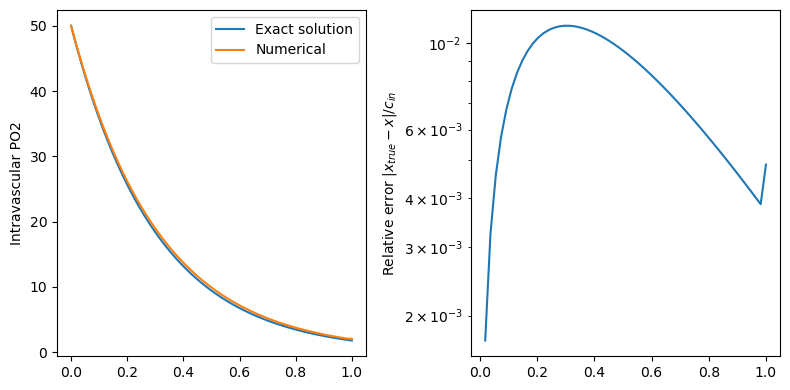

In [13]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(8,4))
s = np.array([np.linalg.norm(CV._vessels.vp['position'][n]) for n in CV._vessels.iter_vertices()])/vy
ax1.plot(s, ExactSol(s*vy)/alpha, label='Exact solution')
ax1.plot(s, x/alpha, label='Numerical')
ax1.legend()
ax1.set_ylabel("Intravascular PO2")

ax2.semilogy(s[1:], abs(ExactSol(s*vy)-x)[1:]/cIn)
ax2.set_ylabel(r"Relative error $|x_{true}-x|/c_{in}$")
fig.tight_layout()
plt.show()

### Adding surrounding tissue sinks manually
Solving -qc'-Gamma_v*S/h_v(c-ct)=0

In [14]:
S = SurfaceArea(CV)

ctBC = 0.6 * cIn

M, Min, Din = ConvectionMatrices(CV)
Convection = M + Min
Reaction   = Gamma_v * S/h_v * (sp.eye(M.shape[0])-Din)

cvBar = Din@(cIn * Min @ np.ones(M.shape[1])) + Reaction @ (np.ones(Reaction.shape[1])*ctBC)

x = spl.spsolve(Convection + Reaction, cvBar)

In [15]:
def ExactSol(s, c0=cIn, ct=ctBC):
    print(f"{c0/alpha=}, {ct/alpha=}")
    # pi*r^2*s = S
    return ct + (c0-ct)*np.exp(-Gamma_v/(h_v*q0)*2*np.pi*r*s)

c0/alpha=50.0, ct/alpha=30.0


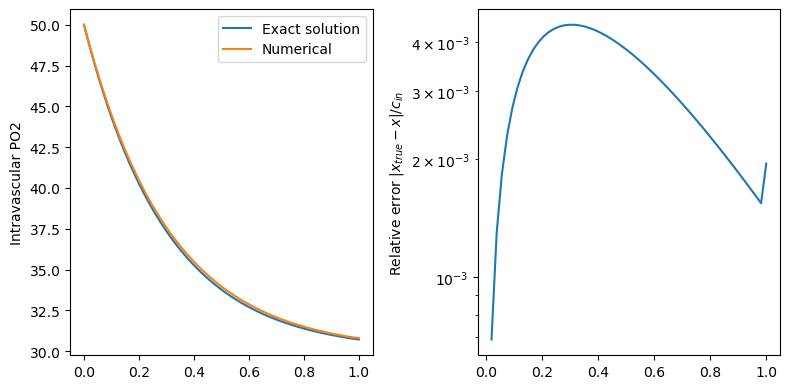

In [16]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(8,4))
s = np.array([np.linalg.norm(CV._vessels.vp['position'][n]) for n in CV._vessels.iter_vertices()])/vy

xtrue = ExactSol(s*vy)

ax1.plot(s, xtrue/alpha, label='Exact solution')
ax1.plot(s, x/alpha, label='Numerical')
ax1.legend()
ax1.set_ylabel("Intravascular PO2")

ax2.semilogy(s[1:], abs(xtrue-x)[1:]/cIn)
ax2.set_ylabel(r"Relative error $|x_{true}-x|/c_{in}$")
fig.tight_layout()
plt.show()

# Testing with real tissue
### Tissue equations forced to constant

In [17]:
import itertools 

def MakeCSRBinaryMatrix(data, nrows:int, ncols:int):
    '''
    Quickly assemble a CSR matrix where the non-zero elements for each row are
    given by their column number.

    ### Parameters
    - data: list[list[int]]
        The non-zero elements of the matrix. 
        Each list correspond to a row and contains the column number of the nnz entry.
    - nrows, ncols: int
        The number of rows and columns of the matrix.
    '''
    # indices = np.concatenate(data)
    indices = np.fromiter(itertools.chain.from_iterable(data), dtype=np.int32)
    # row_indices = np.repeat(np.arange(len(data)), [len(row) for row in data])
    values = np.ones_like(indices)
    indptr = np.concatenate([[0], np.cumsum(np.array([len(row) for row in data]))])    
    return sp.csr_matrix((values, indices, indptr), shape=(nrows,ncols))

def ControlVolumesProjectionMatrices(CV:ControlVolumes):
    endoToVoxel = [l for l in CV.VAG.vp['endothelium']]
    C2t = MakeCSRBinaryMatrix(endoToVoxel, nrows=CV.VAG.num_vertices(), 
        ncols=CV.grid.size)
    C2v = MakeCSRBinaryMatrix([[v] for v in CV.VAG.get_vertices()], nrows=CV.VAG.num_vertices(), 
        ncols=CV._vessels.num_vertices())
    return C2v, C2t
C2v, C2t = ControlVolumesProjectionMatrices(CV)
print(C2v.shape, C2t.shape)

(55, 55) (55, 62500)


### Scale S by number of connected tissue voxels 

In [18]:
def SurfaceArea(CV):
    # N = np.asarray([len(l) for l in CV.VAG.vp['endothelium']])
    # N = np.where(N!=0, 1/N, 0)
    S = np.pi*CV._vessels.ep['radius'].a*(CV._vessels.ep['length'].a/2) 
    C1 = gt.spectral.incidence(CV._vessels)
    S = abs(C1)@S
    # S = np.multiply(N, abs(C1)@S)
    # S = sp.dia_matrix((S, 0), shape=2*[CV._vessels.num_vertices()])
    return S

In [19]:
endo = gt.util.find_edge(coupling, coupling.ep['eType'], 1)
C2v = sp.dok_matrix((CV.VAG.num_vertices(), len(endo)))
C2t = sp.dok_matrix((CV.grid.size, len(endo)))
N   = np.zeros(CV.VAG.num_vertices(), dtype=int)
for i, e in enumerate(endo): 
    u,v = int(e.source()), int(e.target()) 
    C2v[u,i] = 1
    N[u]+=1
    C2t[v, i] = 1
C2v, C2t = C2v.tocsr().T, C2t.tocsr().T
s = SurfaceArea(CV)
s = np.multiply(1/N, s)
S = sp.dia_matrix(([si for si,Ni in zip(s, N) for _ in range(Ni)],0), shape=2*[sum(N)])

In [20]:
B = sp.eye(CV.grid.size)
G = sp.csr_matrix((CV.grid.size, CV._vessels.num_vertices()))

A = Convection + Gamma_v/h_v * C2v.T @ S @ C2v @ (sp.eye(M.shape[0])-Din)
E = -Gamma_v/h_v * (sp.eye(M.shape[0])-Din) @ C2v.T@S@C2t

cvBar = Din@(cIn * Min @ np.ones(M.shape[1])) 
ctBar = np.ones(CV.grid.size) * ctBC

In [21]:
# K = A
# y = -E@ctBar + cvBar 
K = sp.bmat([[A,E], [G,B]]).tocsc()
y = np.hstack([cvBar, ctBar])

# with gmres_counter(disp=1) as callback:
#     x, code = spl.gmres(K, y, callback=callback, maxiter=1000)
x = spl.spsolve(K, y)
# print("Exited with code:", code)

c0/alpha=50.0, ct/alpha=30.0


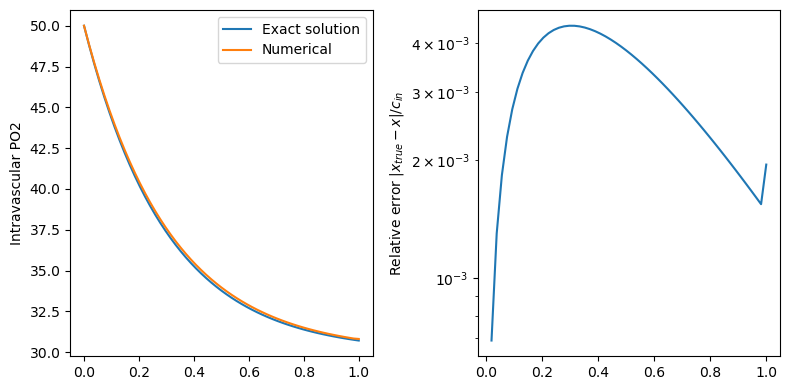

In [22]:
cv, ct = x[:CV._vessels.num_vertices()], x[CV._vessels.num_vertices():]

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(8,4))
s = np.array([np.linalg.norm(CV._vessels.vp['position'][n]) for n in CV._vessels.iter_vertices()])/vy

xtrue = ExactSol(s*vy)

ax1.plot(s, xtrue/alpha, label='Exact solution')
ax1.plot(s, cv/alpha, label='Numerical')
ax1.legend()
ax1.set_ylabel("Intravascular PO2")

ax2.semilogy(s[1:], abs(xtrue-cv)[1:]/cIn)
ax2.set_ylabel(r"Relative error $|x_{true}-x|/c_{in}$")
fig.tight_layout()
plt.show()

### Real problem

In [23]:
lat = gt.generation.lattice(CV.grid.shape)
lat.set_directed(True)
C3 = gt.spectral.incidence(lat)
D3 = sp.dia_matrix(([d!=6 for d in lat.get_total_degrees(lat.get_vertices())], 0), shape=(CV.grid.size, CV.grid.size))
I3 = sp.eye(CV.grid.size)

In [24]:
B = (I3-D3)@(-Gamma_t * (CV.grid.h[0]) * C3@C3.T + k_t * np.prod(CV.grid.h) * I3) + D3
B -= Gamma_v/h_v * C2t.T@S@C2t
G = Gamma_v/h_v * C2t.T @ S @ C2v #@ (sp.eye(M.shape[0])-Din)

A = Convection + Gamma_v/h_v * C2v.T @ S @ C2v @ (sp.eye(M.shape[0])-Din)
E = -Gamma_v/h_v * (sp.eye(M.shape[0])-Din) @ C2v.T@S@C2t

cvBar = Din@(cIn * Min @ np.ones(M.shape[1])) 
ctBar = D3 @ np.ones(CV.grid.size) * ctBC

In [25]:
K = sp.bmat([[A,E], [G,B]]).tocsc()
y = np.hstack([cvBar, ctBar])

# with gmres_counter(disp=1) as callback:
#     ynorm = np.linalg.norm(y)
#     # K/=ynorm
#     # y/=ynorm
#     x, code = spl.gmres(K, y, x0=ctBC + np.zeros_like(y), callback=callback, atol=1e-10, maxiter=10000)
# print("Exited with code:", code)
x = spl.spsolve(K, y)


c0/alpha=50.0, ct/alpha=30.0
40.06360193342915


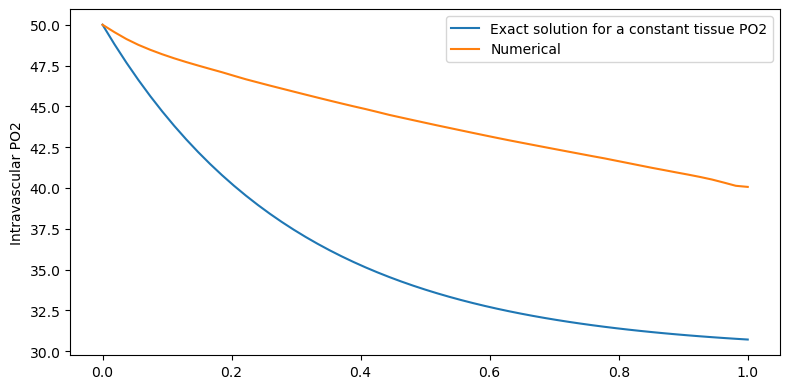

In [26]:
cv, ct = x[:CV._vessels.num_vertices()], x[CV._vessels.num_vertices():]

fig, ax1 = plt.subplots(1,1, figsize=(8,4))
s = np.array([np.linalg.norm(CV._vessels.vp['position'][n]) for n in CV._vessels.iter_vertices()])/vy

xtrue = ExactSol(s*vy)

ax1.plot(s, xtrue/alpha, label='Exact solution for a constant tissue PO2')
ax1.plot(s, cv/alpha, label='Numerical')
ax1.legend()
ax1.set_ylabel("Intravascular PO2")
print(cv.min()/alpha)
# ax2.semilogy(s[1:], abs(xtrue-cv)[1:]/cIn)
# ax2.set_ylabel(r"Relative error $|x_{true}-x|/c_{in}$")
fig.tight_layout()
plt.show()

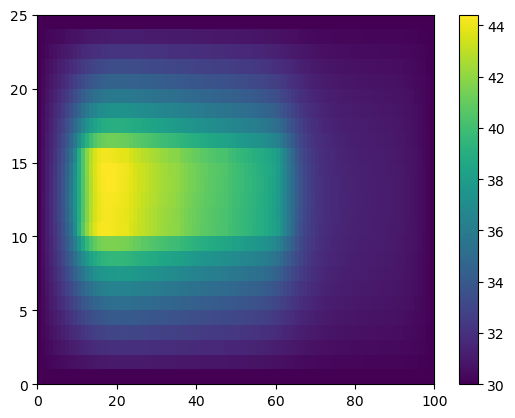

In [27]:
import matplotlib
plt.pcolormesh(ct.reshape(CV.grid.shape)[:, :, int(nz/2)]/alpha)#, norm=matplotlib.colors.LogNorm())
plt.colorbar()
plt.show()

# Real equations

In [28]:
CV = ControlVolumes(Grid(origin=(cx,cy,cz), 
                         sideLengths=(lx,ly,lz), 
                         shape=(nx,ny,nz)), 
                         vessels=VAG)
SplitVessels(CV, CV.grid.h)
q = CV._vessels.new_edge_property("float", q0) # Flow in the vessel (constant -- conservation of mass)
CV._vessels.ep['q'] = q

Refining vascular mesh: 100%|██████████| 3/3 [00:00<00:00, 3704.12edges/s]


In [29]:
from LinearSystems import MakeCouplingMatrices, MakeAll
C2v, C2t, S = MakeCouplingMatrices(CV, h_v)
K, y = MakeAll(CV, C2v, C2t, S, cIn, ctBC, 
               Gamma_t=Gamma_t, Gamma_v=Gamma_v, h_v=h_v, k_t=k_t)
K = sp.bmat(K).tocsr()
y = np.hstack(y)

x = spl.spsolve(K,y)
oldcv = cv.copy()
cv, ct = x[:CV._vessels.num_vertices()], x[CV._vessels.num_vertices():]

Labelling...:   0%|          | 0/54 [00:00<?, ?edge/s]

G.num_edges()=174, G.num_vertices()=62555
G.num_edges()=377, G.num_vertices()=62555
G.num_edges()=580, G.num_vertices()=62555
G.num_edges()=769, G.num_vertices()=62555
G.num_edges()=958, G.num_vertices()=62555
G.num_edges()=1161, G.num_vertices()=62555
G.num_edges()=1350, G.num_vertices()=62555
G.num_edges()=1539, G.num_vertices()=62555
G.num_edges()=1701, G.num_vertices()=62555
G.num_edges()=1863, G.num_vertices()=62555
G.num_edges()=2052, G.num_vertices()=62555
G.num_edges()=2256, G.num_vertices()=62555
G.num_edges()=2418, G.num_vertices()=62555
G.num_edges()=2580, G.num_vertices()=62555
G.num_edges()=2769, G.num_vertices()=62555
G.num_edges()=2958, G.num_vertices()=62555
G.num_edges()=3147, G.num_vertices()=62555
G.num_edges()=3336, G.num_vertices()=62555
G.num_edges()=3525, G.num_vertices()=62555
G.num_edges()=3714, G.num_vertices()=62555
G.num_edges()=3903, G.num_vertices()=62555
G.num_edges()=4092, G.num_vertices()=62555
G.num_edges()=4254, G.num_vertices()=62555
G.num_edges()=44

Labelling...: 100%|██████████| 54/54 [00:00<00:00, 1891.46edge/s]


G.num_edges()=8666, G.num_vertices()=62555
G.num_edges()=8855, G.num_vertices()=62555
G.num_edges()=9044, G.num_vertices()=62555
G.num_edges()=9206, G.num_vertices()=62555
G.num_edges()=9368, G.num_vertices()=62555
G.num_edges()=9557, G.num_vertices()=62555
G.num_edges()=9761, G.num_vertices()=62555
G.num_edges()=9905, G.num_vertices()=62555


Adding endothelium voxels to graph: 100%|██████████| 5857/5857 [00:00<00:00, 640574.67it/s]


40.06360193342923


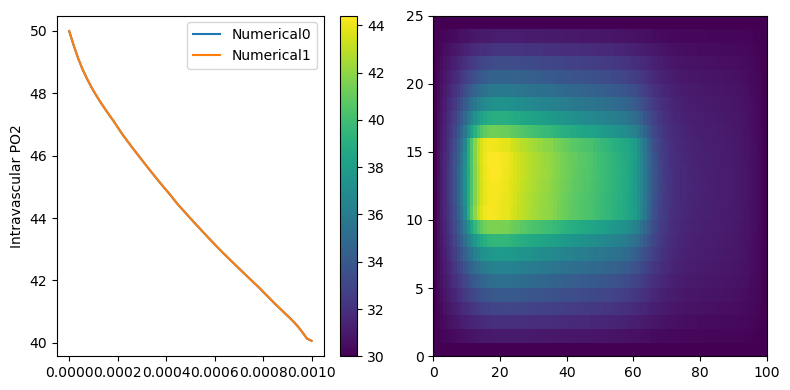

In [30]:
print(cv.min()/alpha)

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(8,4))
s = np.array([np.linalg.norm(CV._vessels.vp['position'][n]) for n in CV._vessels.iter_vertices()])/vy

# ax1.plot(s, xtrue/alpha, label='Exact solution')
ax1.plot(s*vy, cv/alpha, label='Numerical0')
ax1.plot(s*vy, oldcv/alpha, label='Numerical1')
ax1.legend()
ax1.set_ylabel("Intravascular PO2")

cm = ax2.pcolormesh(ct.reshape(CV.grid.shape)[:, :, int(nz/2)]/alpha)
fig.colorbar(cm, ax=ax1)
fig.tight_layout()
plt.show()

oldcv = cv

# On real graph

In [31]:
VAG = VascularGraph("/media/Storage3.6TB/DataForIOVSPaper/200Sims/OCTAMetrics/sim_100_AV.graph")
lx, ly, lz = [1e4*x * convertMicron for x in (.3,.3,.02)]
VAG.vp['position'].set_2d_array(VAG.vp['position'].get_2d_array((0,1,2))*1e4 * convertMicron)
VAG.ep['radius'].a *= 1e4 * convertMicron
VAG.ep['length'].a *= 1e4 * convertMicron

CV = ControlVolumes(Grid((-lx/2, -ly/2, -lz), (lx,ly,lz*1.2), (1200,1200,300)), VAG)
CV._vessels.ep['q'] = CV._vessels.new_edge_property("float", VAG.ep['flow'].a)

In [32]:
SplitVessels(CV, CV.grid.h)

Refining vascular mesh: 100%|██████████| 38577/38577 [00:10<00:00, 3743.65edges/s]


In [33]:
h_v, CV.grid.h, CV._vessels.ep['radius'].a.min()

(1e-05,
 array([2.50208507e-05, 2.50208507e-05, 8.02675585e-06]),
 PropertyArray(2.5e-05))

In [35]:
C2v, C2t, S = MakeCouplingMatrices(CV, h_v)

KeyboardInterrupt: 

In [ ]:
K, y = MakeAll(CV, C2v, C2t, S, cIn, ctBC, 
               Gamma_t=Gamma_t, Gamma_v=Gamma_v, h_v=h_v, k_t=k_t)
K = sp.bmat(K).tocsr()
y = np.hstack(y)

x = spl.spsolve(K,y)
cv, ct = x[:CV._vessels.num_vertices()], x[CV._vessels.num_vertices():]

### Schurr Complement solver

In [ ]:
from LinearSystems import MakeCouplingMatrices, MakeAll

In [ ]:
# CV = ControlVolumes(Grid(origin=(cx,cy,cz), 
#                          sideLengths=(lx,ly,lz), 
#                          shape=(nx,ny,nz)), 
#                          vessels=VAG)
SplitVessels(CV, CV.grid.h)
q = CV._vessels.new_edge_property("float", q0) # Flow in the vessel (constant -- conservation of mass)
CV._vessels.ep['q'] = q
C2v, C2t, S = MakeCouplingMatrices(CV, h_v)

In [ ]:
from scipy.fftpack import dstn, idstn

def LambdasDirichlet(i, N, h):
    ## Eigenvalues of the 3 points laplcian in 1D
    # with Neumann boundary conditions
    # return (2-2*np.cos(i*np.pi/(N+1)))/(h**2)
    return -4*np.sin(i*np.pi/(2*(N)))/(h**2)

def fastPoisson(f, dx,dy,dz, nx,ny,nz):
    dstType = 2
    lambdas = np.sum(
        np.asarray(np.meshgrid(LambdasDirichlet(np.arange(1,nx+1),nx,dx),
                    LambdasDirichlet(np.arange(1,ny+1),ny,dy),
                    LambdasDirichlet(np.arange(1,nz+1),nz,dz),
                    indexing='ij')),
        axis=0)
    u_hat = dstn(f, type=dstType, norm='ortho')/np.where(lambdas==0, np.inf, lambdas)
    u = np.real(idstn(u_hat, type=dstType, norm='ortho'))
    return u

In [ ]:
[[A,E],[G,B]], [cvBar, ctBar] = MakeAll(CV, C2v, C2t, S, cIn, ctBC, 
               Gamma_t=Gamma_t, Gamma_v=Gamma_v, h_v=h_v, k_t=k_t)

triSolve = spl.spsolve_triangular
def Sc_func(x):
    '''Schur complement system'''
    return B@x - (G@triSolve(A, E@x)) 
def Make_bc(bv, bt):
    '''Make the bc for the Schur complement system'''
    return bt - G@(triSolve(A, bv))
def cv_func(ct, cvBar):
    return triSolve(A, cvBar - E@ct)

In [ ]:
Sc = spl.LinearOperator((CV.grid.size, CV.grid.size), Sc_func)
bc = Make_bc(cvBar, ctBar)

# Preconditionner
P = spl.LinearOperator(shape=Sc.shape, 
                       matvec=lambda x: fastPoisson(x.reshape(CV.grid.n), *CV.grid.h, *CV.grid.n).ravel())

In [ ]:
with gmres_counter(disp=100) as callback:
    ct, code = sp.linalg.gmres(Sc, bc, M=P, 
                               tol=1e-8, 
                               restart=10, callback=callback, maxiter=2000)
    print("Exited with code", code)

cv = cv_func(ct, cvBar)

In [ ]:
print(cv.min()/alpha)

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(8,4))
s = np.array([np.linalg.norm(CV._vessels.vp['position'][n]) for n in CV._vessels.iter_vertices()])/vy

# ax1.plot(s, xtrue/alpha, label='Exact solution')
ax1.plot(s*vy, cv/alpha, label='Schurr complement')
# ax1.plot(s*vy, oldcv/alpha, label='Full system')
ax1.legend()
ax1.set_ylabel("Intravascular PO2")

cm = ax2.pcolormesh(ct.reshape(CV.grid.shape)[:, :, int(nz/2)]/alpha)
fig.colorbar(cm, ax=ax1)
fig.tight_layout()
plt.show()